In [103]:
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns
import os
from scipy.spatial import distance
from scripts.vectology_functions import create_aaa_distances, embed_text

Set up some things

In [2]:
os.makedirs('output', exist_ok=True)

Get some variable data

In [161]:
# phewas 

def get_phewas(variant='rs123',pval=1e-3):
    gwas_api_url = "http://gwasapi.mrcieu.ac.uk/phewas"
    payload = {"variant": variant, "pval": pval}
    response = requests.post(gwas_api_url, json=payload)
    res = response.json()
    print(len(res))
    df = pd.json_normalize(res)
    print(df.head())
    return df

trait_df = get_phewas(variant='rs9939609',pval=1e-20)

132
               p      beta       n        se  position chr           id  \
0  3.999450e-115  0.043188  454613  0.001894  53820527  16  ukb-b-16407   
1  7.906790e-190  0.038877  454834  0.001323  53820527  16  ukb-b-14310   
2  8.790230e-176  0.044258  454789  0.001566  53820527  16  ukb-b-12854   
3  3.499450e-207  0.040649  454799  0.001323  53820527  16  ukb-b-17271   
4  8.203520e-214  0.050554  454823  0.001620  53820527  16   ukb-b-7212   

        rsid ea nea       eaf                       trait  
0  rs9939609  A   T  0.394701        Trunk fat percentage  
1  rs9939609  A   T   0.39468  Leg predicted mass (right)  
2  rs9939609  A   T  0.394675  Arm fat percentage (right)  
3  rs9939609  A   T  0.394675   Leg predicted mass (left)  
4  rs9939609  A   T  0.394677         Leg fat mass (left)  


In [162]:
# preprocess the text  

process_text=[]
for k,g in trait_df.groupby(np.arange(len(trait_df))//20):
    params={'text_list':list(g['trait'])}
    process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
    process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
print(len(process_text))
    
trait_df.loc[:, 'processed'] = process_text
print(trait_df.head())

132
               p      beta       n        se  position chr           id  \
0  3.999450e-115  0.043188  454613  0.001894  53820527  16  ukb-b-16407   
1  7.906790e-190  0.038877  454834  0.001323  53820527  16  ukb-b-14310   
2  8.790230e-176  0.044258  454789  0.001566  53820527  16  ukb-b-12854   
3  3.499450e-207  0.040649  454799  0.001323  53820527  16  ukb-b-17271   
4  8.203520e-214  0.050554  454823  0.001620  53820527  16   ukb-b-7212   

        rsid ea nea       eaf                       trait  \
0  rs9939609  A   T  0.394701        Trunk fat percentage   
1  rs9939609  A   T   0.39468  Leg predicted mass (right)   
2  rs9939609  A   T  0.394675  Arm fat percentage (right)   
3  rs9939609  A   T  0.394675   Leg predicted mass (left)   
4  rs9939609  A   T  0.394677         Leg fat mass (left)   

                    processed  
0        trunk fat percentage  
1  leg predicted mass (right)  
2  arm fat percentage (right)  
3   leg predicted mass (left)  
4         leg fat 

Create vectors for each variable

In [163]:
def encode_traits(trait_df):

    vectorList=[]

    #loop through 10 rows at a time
    for k,g in trait_df.groupby(np.arange(len(trait_df))//10):
        #get processed text
        textList=list(g['processed'])
        # embed using BioSentVec initially
        res = embed_text(textList,'BioSentVec')
        
        #add vectors to list
        for i in range(0,len(textList)):
            #ignore empty vectors
            if np.count_nonzero(res[i])>0:
                vectorList.append(res[i])
            else:
                #print('No BioSentVec',textList[i])
                #res2 = embed_text([textList[i]],'biobert_v1.1_pubmed')
                vectorList.append(res[i])

    print(len(vectorList),'vectors created')        
    trait_df['vector'] = vectorList
    return trait_df

trait_df = encode_traits(trait_df)
print(trait_df.head())
#print(trait_df['vector'])

132 vectors created
               p      beta       n        se  position chr           id  \
0  3.999450e-115  0.043188  454613  0.001894  53820527  16  ukb-b-16407   
1  7.906790e-190  0.038877  454834  0.001323  53820527  16  ukb-b-14310   
2  8.790230e-176  0.044258  454789  0.001566  53820527  16  ukb-b-12854   
3  3.499450e-207  0.040649  454799  0.001323  53820527  16  ukb-b-17271   
4  8.203520e-214  0.050554  454823  0.001620  53820527  16   ukb-b-7212   

        rsid ea nea       eaf                       trait  \
0  rs9939609  A   T  0.394701        Trunk fat percentage   
1  rs9939609  A   T   0.39468  Leg predicted mass (right)   
2  rs9939609  A   T  0.394675  Arm fat percentage (right)   
3  rs9939609  A   T  0.394675   Leg predicted mass (left)   
4  rs9939609  A   T  0.394677         Leg fat mass (left)   

                    processed  \
0        trunk fat percentage   
1  leg predicted mass (right)   
2  arm fat percentage (right)   
3   leg predicted mass (left) 

Compare all against all using cosine

In [164]:
# create 2d matrix of vectors
vector_2d = list(trait_df['vector'])
#print(vector_2d)
data = np.array(vector_2d)
print(data.shape)

# do all against all cosine
vector_matrix = create_aaa_distances(vector_2d)

(132, 700)
Creating distances...
132
8646


In [165]:
# create term-score-term triples
def create_triples(vector_matrix, term_list):
    d = []
    mCount=0
    for i in range(0,len(term_list)):
        for j in range(i,len(term_list)):
            if i != j:
                #print(ids[i],ids[j],1-pws[mCount])
                score = 1-vector_matrix[mCount]
                d.append({'source':term_list[i],'score':score,'target':term_list[j]})
                mCount+=1
    df = pd.DataFrame(d)
    print(df.head())
    return df

create_triples(vector_matrix,trait_df['processed'])

                 source     score                      target
0  trunk fat percentage  0.226880  leg predicted mass (right)
1  trunk fat percentage  0.683907  arm fat percentage (right)
2  trunk fat percentage  0.222643   leg predicted mass (left)
3  trunk fat percentage  0.519643         leg fat mass (left)
4  trunk fat percentage  0.377419       body mass index (bmi)


,source,score,target
0,trunk fat percentage,0.226880,leg predicted mass (right)
1,trunk fat percentage,0.683907,arm fat percentage (right)
2,trunk fat percentage,0.222643,leg predicted mass (left)
3,trunk fat percentage,0.519643,leg fat mass (left)
4,trunk fat percentage,0.377419,body mass index (bmi)
...,...,...,...
8641,body mass index,0.297237,type 2 diabetes
8642,body mass index,1.000000,body mass index
8643,type 2 diabetes,1.000000,type 2 diabetes
8644,type 2 diabetes,0.297237,body mass index


Visualise

In [166]:
def plot_compare(dis,name,term_list):
    dis_dic={}
    mCount=0
    for i in range(0,len(term_list)):
        dis_dic[term_list[i]]={}
    for i in range(0,len(term_list)):
        for j in range(i,len(term_list)):
            if i != j:
                score = 1-dis[mCount]
                mCount+=1
                dis_dic[term_list[i]][term_list[j]]=score
                dis_dic[term_list[j]][term_list[i]]=score
    df = pd.DataFrame(dis_dic)
    #sort the rows and columns to be in same order and replace diagonal
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.sort_index()
    #print(df.head())
    #replace NaN with 1 to create perfect maps on the diagonal
    df = df.fillna(1)
    
    sns_plot = sns.clustermap(
        df,
        cmap='coolwarm',
    )
    #sns_plot.ax_heatmap.set_title(name)
    sns_plot.savefig(f"output/{name}.pdf",dpi=1000)
    return df


,age when periods started (menarche),ankle spacing width,ankle spacing width (left),arm fat mass (left),arm fat mass (right),arm fat percentage (left),arm fat percentage (right),arm fat-free mass (left),arm fat-free mass (right),arm predicted mass (left),...,trunk fat-free mass,trunk predicted mass,type 2 diabetes,vascular/heart problems diagnosed by doctor: high blood pressure,waist circumference,waist-to-hip ratio,weight,whole body fat mass,whole body fat-free mass,whole body water mass
age when periods started (menarche),1.000000,0.183768,0.203999,0.273744,0.266497,0.236903,0.246157,0.248288,0.240444,0.137939,...,0.253305,0.149457,0.138622,0.277423,0.188072,0.207317,0.117911,0.234542,0.216421,0.167653
ankle spacing width,0.183768,1.000000,0.942989,0.234874,0.233693,0.237533,0.240330,0.243231,0.241349,0.182321,...,0.198385,0.125956,0.107292,0.160879,0.233200,0.209880,0.137148,0.128494,0.126266,0.144344
ankle spacing width (left),0.203999,0.942989,1.000000,0.338497,0.313614,0.344053,0.316210,0.353145,0.328775,0.305008,...,0.211172,0.149008,0.114200,0.198926,0.245123,0.210653,0.142359,0.124924,0.131526,0.132778
arm fat mass (left),0.273744,0.234874,0.338497,1.000000,0.951541,0.778359,0.736306,0.739494,0.689511,0.617908,...,0.493756,0.332660,0.221390,0.258242,0.403585,0.333005,0.264029,0.654491,0.478368,0.357120
arm fat mass (right),0.266497,0.233693,0.313614,0.951541,1.000000,0.756557,0.775031,0.695447,0.736255,0.572557,...,0.500831,0.338674,0.212593,0.242834,0.402756,0.327497,0.271666,0.649385,0.474772,0.373007
arm fat percentage (left),0.236903,0.237533,0.344053,0.778359,0.756557,1.000000,0.954407,0.609120,0.585250,0.542423,...,0.337459,0.226549,0.177227,0.255425,0.345079,0.318540,0.222907,0.369200,0.319225,0.243875
arm fat percentage (right),0.246157,0.240330,0.316210,0.736306,0.775031,0.954407,1.000000,0.578283,0.611193,0.505510,...,0.346047,0.235486,0.178824,0.259947,0.342713,0.312182,0.222911,0.355423,0.316420,0.245702
arm fat-free mass (left),0.248288,0.243231,0.353145,0.739494,0.695447,0.609120,0.578283,1.000000,0.957459,0.646614,...,0.703815,0.333746,0.119717,0.216551,0.282857,0.236396,0.219581,0.433712,0.715173,0.410914
arm fat-free mass (right),0.240444,0.241349,0.328775,0.689511,0.736255,0.585250,0.611193,0.957459,1.000000,0.602204,...,0.709684,0.338218,0.110253,0.201056,0.280121,0.229641,0.225596,0.425641,0.711245,0.424774
arm predicted mass (left),0.137939,0.182321,0.305008,0.617908,0.572557,0.542423,0.505510,0.646614,0.602204,1.000000,...,0.313981,0.663634,0.076930,0.190819,0.212333,0.153646,0.225538,0.217033,0.278889,0.326475


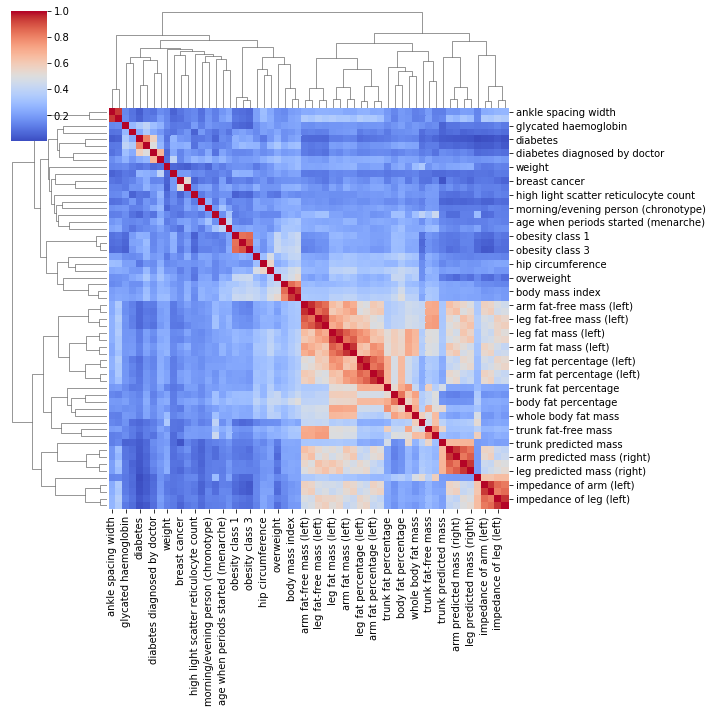

In [167]:
plot_compare(vector_matrix,'test',trait_df['processed'])